In [1]:
import math
import random
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation

In [56]:
# Consensus between two colors ("RED" and "BLUE")
# Adversary try to pivot from RED (initial winner) to BLUE

class Simulator:
    
    def __init__(self, validator_num, adversary_num, slots_per_epoch, init_score):
        assert validator_num % slots_per_epoch == 0        
        self.validator_num = validator_num
        self.adversary_num = adversary_num
        self.slots_per_epoch = slots_per_epoch

        self.validator_id_list = list(range(self.validator_num))
        self.adversary_ids = set(self.validator_id_list[: self.adversary_num])
        self.honest_ids = set(self.validator_id_list[self.adversary_num:])
        assert self.validator_num == len(self.honest_ids) + len(self.adversary_ids)

        # Initial score
        assert init_score[1][0] + init_score[1][1] <= adversary_num
        # Conditions on the result of the previous epoch
        assert init_score[0][0] * 2 < self.validator_num  # Non-convergence
        assert 3 * (init_score[0][0] + init_score[1][0]) < 2 * self.validator_num  # Non-justification
        assert 3 * (init_score[0][0] + self.adversary_num - init_score[1][1]) >= 2 * self.validator_num  # Justifiable
        
        init_red_honest_ids = set(random.sample(self.honest_ids, init_score[0][0])) # Honest validators voting for RED
        init_red_adversary_ids = set(random.sample(self.adversary_ids, init_score[1][0])) # Adversarial validators voting for RED
        init_blue_adversary_ids = set(random.sample(self.adversary_ids - init_red_adversary_ids, init_score[1][1])) # Adversarial validators voting for BLUE

        
        # Latest votes for two colors
        # Index: 0 -> RED, 1 -> BLUE
        self.votes = [{"honest_ids": init_red_honest_ids, "adversary_ids": init_red_adversary_ids},
                      {"honest_ids": self.honest_ids - init_red_honest_ids, "adversary_ids": init_blue_adversary_ids}]
                                     
        # Slot
        self.slot = 0
        self.voters_per_slot = self.validator_num // self.slots_per_epoch
        self.slot_allocation = self.validator_id_list
#         self.slot_allocation = self.validator_id_list[:100] + self.validator_id_list[100:][::-1]
        random.shuffle(self.slot_allocation)

        # Log for visualization
        # Index: slot -> honest/adversary -> red/blue
        self.scores = np.zeros(self.slots_per_epoch * 2 * 2).reshape(self.slots_per_epoch, 2, 2)

        
    def get_red_score(self):
        return len(self.votes[0]["honest_ids"]) + len(self.votes[0]["adversary_ids"])

    def get_blue_score(self):
        return len(self.votes[1]["honest_ids"]) + len(self.votes[1]["adversary_ids"])

    
    def get_winner(self):
        # If there is a tie, RED wins (worse for the adversary)
        return 0 if self.get_red_score() >= self.get_blue_score() else 1

    
    def get_current_voters(self):
        offset = int(self.voters_per_slot * (self.slot % self.slots_per_epoch))
        return set(self.slot_allocation[offset: offset + self.voters_per_slot])

    def batch_vote(self, target, validator_ids):
        non_target = 1 - target
        self.votes[non_target]["honest_ids"] -= validator_ids
        self.votes[non_target]["adversary_ids"] -= validator_ids
        self.votes[target]["honest_ids"] |= validator_ids & self.honest_ids
        self.votes[target]["adversary_ids"] |= validator_ids & self.adversary_ids
        assert self.votes[non_target]["honest_ids"] | self.votes[target]["honest_ids"] == self.honest_ids
        assert self.votes[non_target]["adversary_ids"] | self.votes[target]["adversary_ids"] <= self.adversary_ids

        # Log for visualization
        self.scores[self.slot][0][0] = len(self.votes[0]["honest_ids"])
        self.scores[self.slot][0][1] = len(self.votes[1]["honest_ids"])
        self.scores[self.slot][1][0] = len(self.votes[0]["adversary_ids"])
        self.scores[self.slot][1][1] = len(self.votes[1]["adversary_ids"])
        
    
    def process_slot(self):
        winner = self.get_winner()
        self.batch_vote(winner, self.get_current_voters() & self.honest_ids)
        self.batch_vote(1, self.get_current_voters() & self.adversary_ids)
        self.slot += 1


    def run(self):
        while self.slot < self.slots_per_epoch:
            self.process_slot()
                

def calc_prob_of_pivot(trial_num, validator_num, adversary_num, slots_per_epoch, init_score):
    count = 0
    for i in range(trial_num):
        s = Simulator(validator_num, adversary_num, slots_per_epoch, init_score)
        s.run()    
        count += 1 if s.get_winner() == 1 else 0
    return count / trial_num

In [58]:
# The luckiest case for the adversary
slots_per_epoch = 100
f = 3333
validator_num = f * 3 + 1  # 10000
adversary_num = f

init_score = [[f + 1, f], [0, 0]]

trial_num = 10
print(calc_prob_of_pivot(trial_num, validator_num, adversary_num, slots_per_epoch, init_score))

0.0


## Observations
- A switch of honest validator from BLUE -> RED reduce 2 of the score gap
  - For pivot, adversary must be elected "twice of the switching honest votes + gap"
    - Therefore, the adversary loses on average per slot
- The larger the committee size is, the more mean regressive 
- Once pivot, all of the honest validators vote for BLUE

In [59]:
# 1 voter per slot
slots_per_epoch = 10000
f = 3333
validator_num = f * 3 + 1  # 10000
adversary_num = f

init_score = [[f + 1, f], [0, 0]]

trial_num = 10
print(calc_prob_of_pivot(trial_num, validator_num, adversary_num, slots_per_epoch, init_score))

0.6


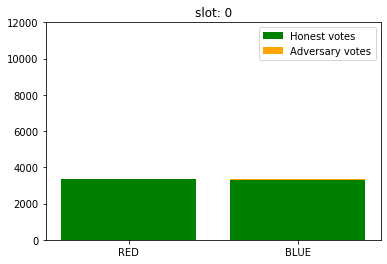

In [64]:
# slots_per_epoch = 64
# validator_num = 131072  # Minimum of ETH2.0
# adversary_num = 43690  # 43690 / 131072 = 0.3333282471...

# The luckiest case for the adversary
slots_per_epoch = 100
f = 3333
validator_num = f * 3 + 1  # 10000
adversary_num = f

init_score = [[f + 1, f], [0, 0]]


s = Simulator(validator_num, adversary_num, slots_per_epoch, init_score)
s.run()    

fig = plt.figure()

def animate(i):
    epoch = int(i // s.slots_per_epoch)
    plt.cla() 
    plt.ylim(0, int(s.validator_num * 1.2))
    plt.title('slot: ' + str(i))
    p1 = plt.bar(["RED", "BLUE"], s.scores[i][0], color="green")
    p2 = plt.bar(["RED", "BLUE"], s.scores[i][1], bottom=s.scores[i][0], color="orange")
    plt.legend((p1[0], p2[0]), ("Honest votes", "Adversary votes"))
    
ani = animation.FuncAnimation(fig, animate, frames=len(s.scores), interval=20)
ani.save('pivot.gif', writer='imagemagick')

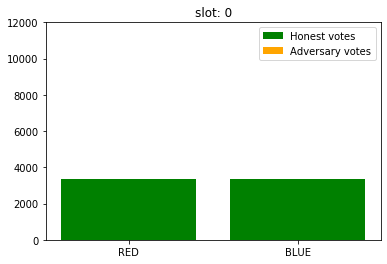

In [63]:
# Animate 1 voter per slot case
slots_per_epoch = 10000
f = 3333
validator_num = f * 3 + 1  # 10000
adversary_num = f

init_score = [[f + 1, f], [0, 0]]


while True:
    s = Simulator(validator_num, adversary_num, slots_per_epoch, init_score)
    s.run()    
    if s.get_winner() == 0:
        continue

    fig = plt.figure()

    def animate(i):
        epoch = int(i // s.slots_per_epoch)
        plt.cla() 
        plt.ylim(0, int(s.validator_num * 1.2))
        plt.title('slot: ' + str(i * 100))
        p1 = plt.bar(["RED", "BLUE"], s.scores[i * 100][0], color="green")
        p2 = plt.bar(["RED", "BLUE"], s.scores[i * 100][1], bottom=s.scores[i * 100][0], color="orange")
        plt.legend((p1[0], p2[0]), ("Honest votes", "Adversary votes"))

    ani = animation.FuncAnimation(fig, animate, frames=len(s.scores) // 100, interval=20)
    ani.save('1-voter-per-epoch-success.gif', writer='imagemagick')
    break